In [ ]:
!pip install transformers datasets

import pandas as ba_pandas
from sklearn.model_selection import train_test_split as ba_train_test_split
from sklearn.metrics import confusion_matrix as ba_confusion_matrix, classification_report as ba_classification_report, ConfusionMatrixDisplay as ba_ConfusionMatrixDisplay
import matplotlib.pyplot as ba_plt
from transformers import BertTokenizer as ba_BertTokenizer, BertForSequenceClassification as ba_BertForSequenceClassification, Trainer as ba_Trainer, TrainingArguments as ba_TrainingArguments
from transformers import DataCollatorWithPadding as ba_DataCollatorWithPadding
import torch as ba_torch
from datasets import Dataset as ba_Dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load the British Airways Country and Reviews da dataset
ba_reviews_df = ba_pandas.read_csv('/content/drive/My Drive/ba_reviews.csv')

# Retain only the 'content' and 'recommended' columns for analysis
ba_reviews_df = ba_reviews_df[['content', 'recommended']]

# Map 'recommended' values to numeric: "yes" -> 1, "no" -> 0
ba_reviews_df['recommended'] = ba_reviews_df['recommended'].map({'yes': 1, 'no': 0})

# Split the dataset into training and testing sets
ba_train_df, ba_test_df = ba_train_test_split(ba_reviews_df, test_size=0.2, random_state=42)

# Convert the training and testing DataFrames into Hugging Face Dataset format
ba_train_dataset = ba_Dataset.from_pandas(ba_train_df)
ba_test_dataset = ba_Dataset.from_pandas(ba_test_df)

# Load the British Airways tokenizer for BERT
ba_tokenizer = ba_BertTokenizer.from_pretrained('bert-base-uncased')

# Update the tokenization function to include labels
def ba_tokenize_function(examples):
    # Tokenize the 'content' column and add the 'recommended' labels
    return ba_tokenizer(examples['content'], truncation=True, padding=True)

# Tokenize the datasets
ba_train_dataset = ba_train_dataset.map(lambda examples: {'input_ids': ba_tokenize_function(examples)['input_ids'],
                                                          'attention_mask': ba_tokenize_function(examples)['attention_mask'],
                                                          'labels': examples['recommended']}, batched=True)

ba_test_dataset = ba_test_dataset.map(lambda examples: {'input_ids': ba_tokenize_function(examples)['input_ids'],
                                                        'attention_mask': ba_tokenize_function(examples)['attention_mask'],
                                                        'labels': examples['recommended']}, batched=True)


# Create a data collator for padding during training
ba_data_collator = ba_DataCollatorWithPadding(tokenizer=ba_tokenizer)

# Load the pre-trained BERT model for sequence classification
ba_model = ba_BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/1059 [00:00<?, ? examples/s]

Map:   0%|          | 0/265 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define a function to compute evaluation metrics
def ba_compute_metrics(pred):
    labels = pred.label_ids
    preds = ba_torch.argmax(ba_torch.tensor(pred.predictions), dim=1)

    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


# Set up training arguments specific to the British Airways Country and Reviews da dataset
ba_training_args = ba_TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
)

# Initialize the Trainer with the model, training arguments, and datasets
ba_trainer = ba_Trainer(
    model=ba_model,
    args=ba_training_args,
    train_dataset=ba_train_dataset,
    eval_dataset=ba_test_dataset,
    tokenizer=ba_tokenizer,
    data_collator=ba_data_collator,
    compute_metrics=ba_compute_metrics,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Train the BERT model using the British Airways Country and Reviews da dataset
ba_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.057600,0.329452,0.932075,0.917431,0.909091,0.925926
2,0.116400,0.331493,0.932075,0.917431,0.909091,0.925926
3,0.002300,0.374472,0.924528,0.911504,0.872881,0.953704


TrainOutput(global_step=201, training_loss=0.06172938732921484, metrics={'train_runtime': 364.7825, 'train_samples_per_second': 8.709, 'train_steps_per_second': 0.551, 'total_flos': 835903822878720.0, 'train_loss': 0.06172938732921484, 'epoch': 3.0})

In [ ]:
# Evaluate the model's performance on the test dataset
ba_predictions = ba_trainer.predict(ba_test_dataset)
ba_preds = ba_torch.argmax(ba_torch.tensor(ba_predictions.predictions), dim=1)

# Generate a classification report for the test dataset
print(ba_classification_report(ba_test_df['recommended'], ba_preds))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       157
           1       0.87      0.95      0.91       108

    accuracy                           0.92       265
   macro avg       0.92      0.93      0.92       265
weighted avg       0.93      0.92      0.92       265



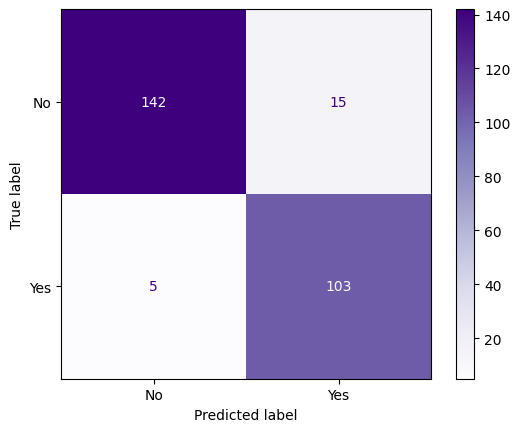

In [ ]:
# Generate and display the confusion matrix using a purple color map
ba_cm = ba_confusion_matrix(ba_test_df['recommended'], ba_preds)
ba_disp = ba_ConfusionMatrixDisplay(confusion_matrix=ba_cm, display_labels=["No", "Yes"])

# Plot the confusion matrix in purple
ba_disp.plot(cmap='Purples')
ba_plt.show()

In [ ]:
# Show a few sample predictions from the test dataset
ba_test_df['predicted'] = ba_preds
ba_test_df[['content', 'recommended', 'predicted']].sample(4)

,content,recommended,predicted
654,London Heathrow to Singapore on 28 May 2018....,1,1
1006,I had to change my flight back from San Dieg...,0,0
371,The start of our journey back from from EFL w...,1,1
673,Hamburg to Abu Dhabi via London. Hamburg to ...,0,0
